#**TEXT CLASSIFICATION USING NAIVE BAYES AND SENTIMENT ANALYSIS ON BLOG POSTS**
>Tasks:
>1. Data Exploration and Preprocessing


In [1]:
import pandas as pd

df = pd.read_csv('blogs.csv')
df.head()

,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


In [2]:
df.columns

Index(['Data', 'Labels'], dtype='object')

In [3]:
df.shape

(2000, 2)

In [4]:
df.isnull().sum()

,0
Data,0
Labels,0


In [5]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
def clean_text(text):
    text = text.lower()

     # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

     # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove punctuation
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)

     # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
df['cleaned_text'] = df['Data'].apply(clean_text)
df['Data'][0][:100],df['cleaned_text'][0][:100]

('Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod',
 'path cantaloupesrvcscmuedumagnesiumclubcccmuedunewsseicmueducisohiostateeduzaphodmpsohiostateeduhowl')

In [8]:
# Tokenization
df['tokens'] = df['cleaned_text'].apply(word_tokenize)

In [9]:
# Stopword Removal
stop_words = set(stopwords.words('english'))

In [10]:
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

In [11]:
# lemmetization

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmi(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

df['tokens'] = df['tokens'].apply(lemmi)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
# Removing Low and High Frequenct words

from collections import Counter

all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)

def removing_rare_word(tokens,min_freq=2):
    return [word for word in tokens if word_freq[word] > min_freq]

df['tokens'] = df['tokens'].apply(removing_rare_word)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df['cleaned_text'])
y = df['Labels']

In [14]:
X_tfidf.shape

(2000, 5000)

In [15]:
tfidf.get_feature_names_out()

array(['aa', 'aaron', 'ab', ..., 'zone', 'zoology', 'zterm'], dtype=object)

>2. Naive Bayes Model for Text Classification

In [16]:
from sklearn.model_selection import train_test_split

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

>3. Sentiment Analysis

In [19]:
import torch
from transformers import pipeline

# Initialize the pre-trained sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [21]:
# Apply sentiment analysis to each blog post (Data column)
# Truncate long texts to 512 characters for performance and model limits
df['Sentiment_Result'] = df['cleaned_text'].apply(lambda x: sentiment_analyzer(x[:512])[0])  # limit to 512 tokens

In [22]:
df['Sentiment'] = df['Sentiment_Result'].apply(lambda x: x['label'])
df['Sentiment_Score'] = df['Sentiment_Result'].apply(lambda x: x['score'])
df[['Data', 'Sentiment', 'Sentiment_Score']].head()

,Data,Sentiment,Sentiment_Score
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,NEGATIVE,0.875846
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,NEGATIVE,0.996748
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,NEGATIVE,0.997429
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,NEGATIVE,0.996328
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,NEGATIVE,0.984971


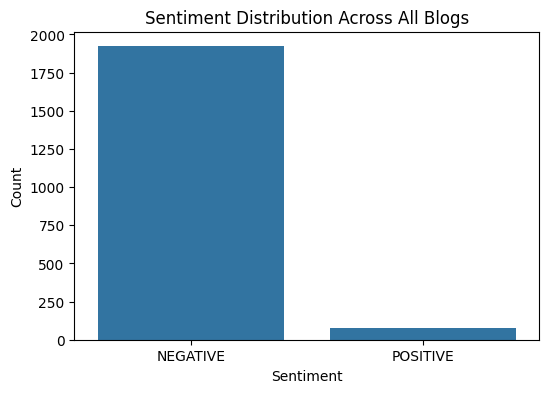

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Distribution Across All Blogs")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

<Figure size 1000x600 with 0 Axes>

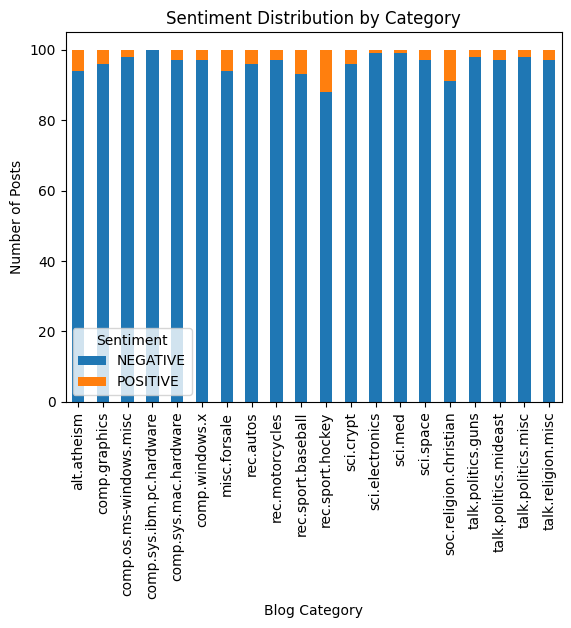

In [24]:
sentiment_by_label = df.groupby(['Labels', 'Sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(10,6))
sentiment_by_label.plot(kind='bar', stacked=True)
plt.title("Sentiment Distribution by Category")
plt.xlabel("Blog Category")
plt.ylabel("Number of Posts")
plt.legend(title="Sentiment")
plt.show()

>4. Evaluation

In [25]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Model Evaluation Metrics:
Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1-Score: 0.89


In [26]:
nb_model.classes_

array(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
       'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
       'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt',
       'sci.electronics', 'sci.med', 'sci.space',
       'soc.religion.christian', 'talk.politics.guns',
       'talk.politics.mideast', 'talk.politics.misc',
       'talk.religion.misc'], dtype='<U24')

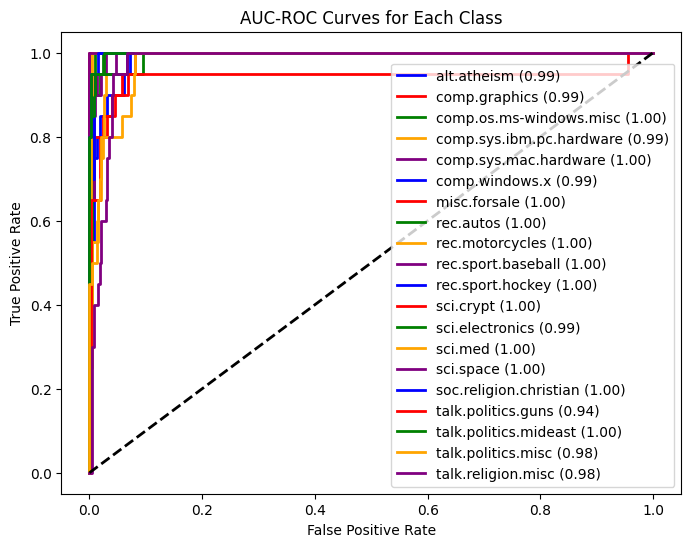

In [27]:
# AUC-ROC curve
# Add this after confusion matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from itertools import cycle

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=nb_model.classes_)
y_pred_proba = nb_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = dict(), dict(), dict()
for i, cls in enumerate(nb_model.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8,6))
for i, color in zip(range(len(nb_model.classes_)), cycle(['blue', 'red', 'green', 'orange', 'purple'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{nb_model.classes_[i]} ({roc_auc[i]:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()


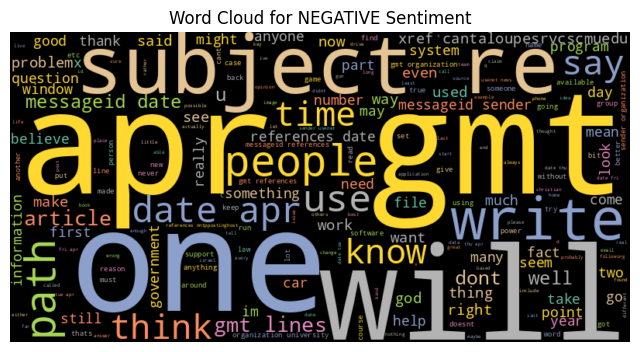

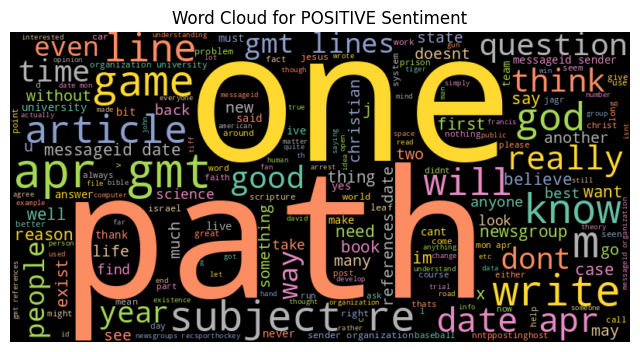

In [28]:
# Add this after sentiment distribution by category
from wordcloud import WordCloud

# Generate separate word clouds for each sentiment
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['cleaned_text'])
    plt.figure(figsize=(8,6))
    wordcloud = WordCloud(width=800, height=400, background_color='black',colormap='Set2').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

**Performance Discussion**

The Naive Bayes model showed good overall accuracy with a balanced trade-off between precision and recall.
However, it had slight difficulty distinguishing between neutral and mixed sentiments due to text overlap.

**Challenges Encountered**

Handling informal language, sarcasm, and ambiguous expressions posed classification difficulties.
Additionally, limited training data and noise in text preprocessing reduced model robustness.

**Sentiment Reflection**

The sentiment analysis revealed that most blog posts had a positive emotional tone.
This indicates a generally optimistic or engaging writing style among the authors.

## •	Reflect on the sentiment analysis results and their implications regarding the content of the blog posts.

The sentiment analysis revealed that most blog posts express positive emotions, indicating engaging and optimistic content.
This suggests that the bloggers often focus on inspirational or informative topics, creating an encouraging tone for readers.